In [203]:
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

In [291]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [289]:
datadir = '/cellar/users/snwright/Data/RareCommon/'
inputdir = os.path.join(datadir, 'inputs/UKB/')
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/Figure_UKB_Inputs/'

In [12]:
pc_nodes = pd.read_csv(os.path.join(datadir, 'inputs', 'pcnet2_0_nodes.txt' ), sep='\t', header=None, names=['Entrez', 'degree']).Entrez.values

## GWASAtlas

In [49]:
info = pd.read_csv(os.path.join(datadir, 'GWASAtlas','gwasATLAS_v20191115.txt.gz' ), sep='\t', low_memory=False, index_col=0)
info.shape
info['ga_idx'] = [x for x in range(1, len(info)+1)]

ga_map = pd.read_csv(os.path.join(datadir, 'GWASAtlas','gda_entrez_mapped.tsv' ), sep='\t', index_col=0, usecols=['GENE', 'Entrez'])
ga_gda = pd.read_csv(os.path.join(datadir, 'GWASAtlas', 'gwasATLAS_v20191115_magma_P.txt.gz'), sep='\t')
ga_gda = ga_gda.merge(ga_map, on='GENE', how='inner')
ga_gda = ga_gda[ga_gda.Entrez.isin(pc_nodes)]

In [50]:
print(f'Unique domains: {info.Domain.nunique()}')
print(f'Unique chapters: {info.ChapterLevel.nunique()}')
print(f'Unique subchapters: {info.SubchapterLevel.nunique()}')
print(f'Unique traits: {info.Trait.nunique()}')
print(f'Unique UniqTraits: {info.uniqTrait.nunique()}')
print(f'Unique PMID: {info.PMID.nunique()}')
print(f'Unique Consortium: {info.Consortium.nunique()}')
print(f'Unique Populations: {info.Population.nunique()}')

Unique domains: 28
Unique chapters: 55
Unique subchapters: 209
Unique traits: 4363
Unique UniqTraits: 3307
Unique PMID: 473
Unique Consortium: 40
Unique Populations: 34


In [51]:
ukb_ids = ['UKB2 (EUR)', 'UKB1 (EUR)']

In [59]:
ukb_info = info[info.Population.isin(ukb_ids)]

In [60]:
print(f'Unique domains: {ukb_info.Domain.nunique()}')
print(f'Unique chapters: {ukb_info.ChapterLevel.nunique()}')
print(f'Unique subchapters: {ukb_info.SubchapterLevel.nunique()}')
print(f'Unique traits: {ukb_info.Trait.nunique()}')
print(f'Unique UniqTraits: {ukb_info.uniqTrait.nunique()}')
print(f'Unique PMID: {ukb_info.PMID.nunique()}')
print(f'Unique Consortium: {ukb_info.Consortium.nunique()}')
print(f'Unique Populations: {ukb_info.Population.nunique()}')

Unique domains: 24
Unique chapters: 42
Unique subchapters: 116
Unique traits: 961
Unique UniqTraits: 865
Unique PMID: 159
Unique Consortium: 5
Unique Populations: 2


In [61]:
# remove any with missing N
ukb_info = ukb_info[~ukb_info.N.isna()]
#restrict to those with at least 3 hits
ukb_info = ukb_info[ukb_info.Nhits >= 3]
# remove any with missing Genome information
ukb_info = ukb_info[~ukb_info.Genome.isna()]
ukb_info.shape

(471, 29)

In [55]:
# keep studies with at least 3 pcnet assoc
assoc_counts = (ga_gda.iloc[:, 1:-2] < 1e-4).sum(axis=0)
drop_small = assoc_counts[assoc_counts<3].index.values
# remove studies with > 1000 pcnet assoc
drop_large = assoc_counts[assoc_counts>1000].index.values

In [64]:
ukb_info = ukb_info[(~ukb_info.ga_idx.isin([int(x) for x in drop_small])) & (~ukb_info.ga_idx.isin([int(x) for x in drop_large]))]

In [65]:
def extract_phecode(s):
    if isinstance(s, str):
        parts = [x for x in s.split('. ')]
        for p in parts:
            if 'UKB phenotype field' in p:
                return p.split(': ')[-1].split(' (')[0]
        else:
            return np.nan
    else:
        return np.nan

In [66]:
# extract ukb_phecodes where available in notes
ukb_info['phecode'] = ukb_info.Note.apply(lambda x: extract_phecode(x))

In [67]:
ukb_info['phecode'].value_counts()

phecode
134      1
2897     1
2704     1
2724     1
2734     1
        ..
1498     1
1518     1
1528     1
1538     1
20525    1
Name: count, Length: 169, dtype: int64

Notes field: (need to figure out how to extract)

- 'Population prevalence:'
- 'Case-control GWAS.'
- 'Factor score GWAS.'
- 'Quantitative phenotype'
- 'Dichotomized phetnotype'

In [68]:
# percent missing values
(info.isna().sum()/len(info)).sort_values(ascending=False) * 100

Consortium          90.664424
SNPh2_l_se          87.510513
SNPh2_l             87.510513
Ncase               84.377628
Ncontrol            84.377628
SNPh2               52.460050
Intercept           52.460050
Chi2                52.460050
LambdaGC            52.460050
SNPh2_z             52.460050
SNPh2_se            52.460050
Note                 9.188394
Website              1.619008
Genome               0.315391
DateLastModified     0.000000
DateAdded            0.000000
PMID                 0.000000
Nhits                0.000000
Nsnps                0.000000
Year                 0.000000
N                    0.000000
Population           0.000000
uniqTrait            0.000000
Trait                0.000000
SubchapterLevel      0.000000
ChapterLevel         0.000000
Domain               0.000000
File                 0.000000
ga_idx               0.000000
dtype: float64

In [69]:
ukb_info['Trait'] = ukb_info['Trait'].apply(lambda x: x.lower())
ukb_info['uniqTrait'] = ukb_info['uniqTrait'].apply(lambda x: x.lower())

## Genebass

In [71]:
phenos = pd.read_csv(os.path.join(datadir,'GeneBASS/', 'genebass_pheno_df_full.txt'), sep='\t', index_col=0)
phenos['description'] = phenos['description'].apply(lambda z: z.lower() if isinstance(z, str) else np.nan)
phenos['coding_description'] = phenos['coding_description'].apply(lambda z: z.lower() if isinstance(z, str) else np.nan)
phenos['n_controls'] = phenos['n_controls'].fillna(0)
phenos['N'] = phenos['n_cases'] + phenos['n_controls']
phenos['gb_idx'] = [x for x in range(len(phenos))]

In [72]:
len(phenos)

4529

In [73]:
phenos = phenos.dropna(subset='N')

In [74]:
phenos=phenos.sort_values(by='N', ascending=False)

### Test SBERT

In [78]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [88]:
def compute_bidirectional_matches(embeddings1, embeddings2, series1, series2):
    """
    Computes the best matches between two pandas Series of text using SBERT.
    
    For each entry in series1, it finds the best matching entry in series2 and vice versa.
    The results are combined into a single DataFrame with a 'Direction' column.
    
    Parameters:
        series1 (pd.Series): A pandas Series with text entries. The Series index is preserved.
        series2 (pd.Series): A pandas Series with text entries. The Series index is preserved.
        model_name (str): The name of the SentenceTransformer model to use.
        batch_size (int): Batch size for encoding.
        show_progress_bar (bool): Whether to show the progress bar during encoding.
    
    Returns:
        pd.DataFrame: A DataFrame containing the results from both matching directions.
    """
    # Convert Series to lists (order is maintained)
    list1 = series1.tolist()
    list2 = series2.tolist()
    
    # Compute the cosine similarity matrix between embeddings from series1 and series2
    cos_sim_matrix = cosine_similarity(embeddings1, embeddings2)
    
    # -------------------------------
    # Matches: Series1 -> Series2
    # -------------------------------
    best_match_indices_1_to_2 = np.argmax(cos_sim_matrix, axis=1)
    best_match_scores_1_to_2 = np.max(cos_sim_matrix, axis=1)
    
    # Create a DataFrame for matches from series1 to series2 with standardized column names
    df1_to_2 = pd.DataFrame({
        "Direction": "Series1_to_Series2",
        "Query_Index": series1.index,
        "Query_Text": list1,
        "Match_Index": [series2.index[i] for i in best_match_indices_1_to_2],
        "Match_Text": [list2[i] for i in best_match_indices_1_to_2],
        "Cosine_Similarity": best_match_scores_1_to_2
    })
    
    # -------------------------------
    # Matches: Series2 -> Series1
    # -------------------------------
    best_match_indices_2_to_1 = np.argmax(cos_sim_matrix, axis=0)
    best_match_scores_2_to_1 = np.max(cos_sim_matrix, axis=0)
    
    # Create a DataFrame for matches from series2 to series1 with standardized column names
    df2_to_1 = pd.DataFrame({
        "Direction": "Series2_to_Series1",
        "Query_Index": series2.index,
        "Query_Text": list2,
        "Match_Index": [series1.index[i] for i in best_match_indices_2_to_1],
        "Match_Text": [list1[i] for i in best_match_indices_2_to_1],
        "Cosine_Similarity": best_match_scores_2_to_1
    })
    
    # Combine both DataFrames into one for downstream analysis.
    combined_df = pd.concat([df1_to_2, df2_to_1], ignore_index=True)
    
    return combined_df.sort_values(by='Cosine_Similarity', ascending=False)

def extract_mutual_matches(bidirectional_df):

 # Split the bidirectional DataFrame by direction.
    df1_to_2 = bidirectional_df[bidirectional_df['Direction'] == 'Series1_to_Series2'].copy()
    df2_to_1 = bidirectional_df[bidirectional_df['Direction'] == 'Series2_to_Series1'].copy()

    # Rename columns for df1_to_2.
    df1_to_2.rename(columns={
        "Query_Index": "Series1_Index",
        "Query_Text": "Series1_Text",
        "Match_Index": "Series2_Index",
        "Match_Text": "Series2_Text",
        "Cosine_Similarity": "Cosine_Similarity_1"
    }, inplace=True)

    # Rename columns for df2_to_1.
    df2_to_1.rename(columns={
        "Query_Index": "Series2_Index",
        "Query_Text": "Series2_Text",
        "Match_Index": "Series1_Index",
        "Match_Text": "Series1_Text",
        "Cosine_Similarity": "Cosine_Similarity_2"
    }, inplace=True)

    # Merge the two DataFrames on Series1_Index and Series2_Index.
    mutual = pd.merge(df1_to_2, df2_to_1, on=["Series1_Index", "Series2_Index"], suffixes=('_1', '_2'))
    
    # Compute the average cosine similarity.
    mutual["Average_Cosine_Similarity"] = (mutual["Cosine_Similarity_1"] + mutual["Cosine_Similarity_2"]) / 2.0

    # Select columns for output. Here we choose the text columns from the first direction (suffix _1).
    result = mutual[[
        "Series1_Index", "Series1_Text_1", "Series2_Index", "Series2_Text_1", "Average_Cosine_Similarity"
    ]].copy()
    
    # Rename the suffixed text columns to standard names.
    result.rename(columns={"Series1_Text_1": "Series1_Text", "Series2_Text_1": "Series2_Text"}, inplace=True)
    
    return result


In [79]:
# Load the pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

## BERT matching of Genebass and GwasAtlas

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def get_all_matchesx(series1, series2, emb1, emb2, th=0.8):
    """
    Given two pandas Series (series1 and series2) along with their precomputed embeddings (emb1 and emb2),
    compute the cosine similarity between every string from series1 and every string from series2.
    
    Returns a DataFrame with all pairs (one string from each Series) having a cosine similarity >= th.
    Each row includes:
      - Series1_Index, Series1_Text,
      - Series2_Index, Series2_Text,
      - Cosine_Similarity.
    
    Parameters:
      series1 (pd.Series): Series of strings (with index) for list1.
      series2 (pd.Series): Series of strings (with index) for list2.
      emb1 (np.ndarray): Embeddings for the strings in series1 (assumed to correspond in order to series1.index).
      emb2 (np.ndarray): Embeddings for the strings in series2.
      th (float): Cosine similarity threshold (default=0.8).
    
    Returns:
      pd.DataFrame: DataFrame containing all unique pairs with similarity >= th.
    """
    # Compute the cosine similarity matrix between emb1 and emb2.
    sim_matrix = cosine_similarity(emb1, emb2)
    
    pairs = []
    # Loop over rows (series1) and columns (series2) to collect pairs meeting threshold.
    n1, n2 = sim_matrix.shape
    for i in range(n1):
        for j in range(n2):
            sim = sim_matrix[i, j]
            if sim >= th:
                pairs.append({
                    "Series1_Index": series1.index[i],
                    "Series1_Text": series1.iloc[i],
                    "Series2_Index": series2.index[j],
                    "Series2_Text": series2.iloc[j],
                    "Cosine_Similarity": sim
                })
    
    # Create DataFrame of matches.
    matches_df = pd.DataFrame(pairs)
    # (If the same pair could be found twice by any chance, drop duplicates.)
    matches_df.drop_duplicates(inplace=True)
    # Optionally, sort by descending similarity.
    matches_df.sort_values(by="Cosine_Similarity", ascending=False, inplace=True)
    return matches_df


In [81]:
# first direct matches based on phecodes - do not use 'coding' from genebass will give incorrect matches
phe_match = phenos.merge(ukb_info, left_on='phenocode', right_on='phecode', how='inner')
phe_match.shape

(30, 50)

In [82]:
ga_match_ids = list(phe_match.ga_idx.values)

#### Descriptions

In [114]:
# get the traits where we will use the description column
desc_counts = phenos.description.value_counts()
use_description = phenos[~phenos.description.isin(desc_counts[desc_counts>10].index.values)]
use_description = use_description[~use_description.description.isna()]
use_description.shape

(2093, 20)

In [115]:
# get embeddings
ga_embeddings = model.encode(list(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)]['Trait'].values), batch_size=32, show_progress_bar=True)
bass_embeddings1 = model.encode(use_description.description.values, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

In [116]:
desc_df = compute_bidirectional_matches(ga_embeddings, bass_embeddings1, 
                                        ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
                                        use_description.set_index('gb_idx').description)
desc_out = extract_mutual_matches(desc_df)

In [76]:
#ga_desc = get_all_matches(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
#                          use_description.set_index('gb_idx').description, 
#                          ga_embeddings, bass_embeddings1, th=0.7)

#### Coding descriptions

In [140]:
use_coding = phenos[(~phenos.coding_description.isna())]
use_coding['full_description'] = use_coding['description'] + ' ' + use_coding['coding_description']
bass_embeddings2 = model.encode(use_coding.full_description.values, batch_size=32, show_progress_bar=True)


/tmp/ipykernel_2532028/2676421464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_coding['full_description'] = use_coding['description'] + ' ' + use_coding['coding_description']


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

In [149]:
coding_df = compute_bidirectional_matches(ga_embeddings, bass_embeddings2, 
                                        ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
                                        use_coding.set_index('gb_idx').full_description)
coding_out = extract_mutual_matches(coding_df)

In [150]:
coding_out

,Series1_Index,Series1_Text,Series2_Index,Series2_Text,Average_Cosine_Similarity
0,4276,carpal tunnel syndrome,210,"non-cancer illness code, self-reported carpal ...",0.730365
1,4311,diverticular disease,164,"non-cancer illness code, self-reported diverti...",0.728060
2,3190,number of self-reported non-cancer illnesses,83,"non-cancer illness code, self-reported psychol...",0.714881
3,4237,antihistamines for systemic use,543,treatment/medication code antihistamine 60mg t...,0.712241
4,3393,number of depression episodes,875,bipolar and major depression status single pro...,0.699889
...,...,...,...,...,...
60,4448,left entorhinal,1176,operative procedures - main opcs4 j38.9 unspec...,0.367268
61,3324,relative age of first facial hair (male),1388,operative procedures - main opcs4 s06.3 shave ...,0.357934
62,4305,trunk-trunk fat ratio (male),2317,operative procedures - secondary opcs4 z49.8 s...,0.343400
63,3315,use of sun/uv protection,1089,operative procedures - main opcs4 f32.4 operat...,0.337101


In [78]:
#ga_coding = get_all_matches(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
#                          use_coding.set_index('gb_idx').coding_description, 
#                          ga_embeddings, bass_embeddings2, th=0.7)

#### Combine dfs and identify groups

In [151]:
ga_all = pd.concat([desc_out, coding_out])

In [152]:
ga_all = ga_all.sort_values('Average_Cosine_Similarity', ascending=False).drop_duplicates('Series1_Index')
ga_all.columns = ['ga_idx', 'Trait', 'gb_idx', 'description', 'Cosine']

In [153]:
phe_combined = phe_match.loc[:, ('ga_idx', 'Trait', 'gb_idx', 'description')]
phe_combined['Cosine'] = 1.0

In [165]:
all_matches = pd.concat([ga_all, phe_combined])

In [166]:
all_matches = all_matches.sort_values(by='Cosine', ascending=False).drop_duplicates('ga_idx').drop_duplicates('gb_idx')

In [167]:
all_matches.to_csv('/cellar/users/snwright/Data/Transfer/RVC/data/gb_ga_trait_cosines.txt', sep='\t')

In [159]:
keep_matches = pd.read_csv(os.path.join('/cellar/users/snwright/Data/Transfer/RVC/data/RV Study Info - UKB shared traits.tsv'), sep='\t', index_col=0)
keep_matches.head()

,ga_idx,Trait,gb_idx,description,Cosine,Keep
29,3720,frequency of failure to fulfil normal expectat...,2640,frequency of failure to fulfil normal expectat...,1.0,1
0,3235,current tobacco smoking,2599,current tobacco smoking,1.0,1
2,3328,diabetes (diagnosed by doctor),933,diabetes diagnosed by doctor,1.0,1
3,3329,cancer (diagnosed by doctor),934,cancer diagnosed by doctor,1.0,1
4,3302,"seen a psychiatrist for nerves, anxiety, tensi...",922,"seen a psychiatrist for nerves, anxiety, tensi...",1.0,1


In [171]:
all_matches = all_matches.merge(keep_matches.loc[keep_matches.Keep==1, ('ga_idx', 'gb_idx') ], on=['ga_idx', 'gb_idx'], how='inner')

### Export

In [172]:
ukb_info_out = ukb_info[ukb_info.ga_idx.isin(all_matches.ga_idx.values)]

In [173]:
ukb_info_out.drop_duplicates(subset=['PMID', 'Trait', 'Population']).shape

(96, 30)

In [174]:
ukb_info_out = ukb_info_out.assign(Population= ukb_info_out.Population.map({'UKB1 (EUR)':'UKB1', 'UKB2 (EUR)':'UKB2', 
                                                             'UKB2 (EUR meta)':'UKB2meta', 'UKB1 (EUR meta)':'UKB1meta'}))

In [175]:
ukb_info_out.Population.unique()

array(['UKB1', 'UKB2'], dtype=object)

In [176]:
ukb_info_out['StudyC'] = 'GA_idx'+ukb_info_out.ga_idx.astype(str) +'_'+ ukb_info_out.Population + '_' + ukb_info_out.PMID.astype(str)

In [177]:
ukb_info_out.drop(columns=['File', 'Website', 'Consortium', 'DateAdded', 'DateLastModified']).to_csv('/cellar/users/snwright/Data/RareCommon/GWASAtlas/UKB_Atlas_Genebass_matched_traits2.tsv', sep='\t', index=False)

In [178]:
phenos_out1 = phenos[phenos.gb_idx.isin(all_matches.gb_idx.values)]

In [179]:
phenos_out1['StudyR'] = 'GB_UKB_idx' + phenos_out1.gb_idx.astype(str) + '_phe' + phenos_out1.phenocode.astype(str)

/tmp/ipykernel_2532028/2085730337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenos_out1['StudyR'] = 'GB_UKB_idx' + phenos_out1.gb_idx.astype(str) + '_phe' + phenos_out1.phenocode.astype(str)


In [181]:
phenos_out1.shape

(96, 21)

In [184]:
phenos_out1.to_csv('/cellar/users/snwright/Data/RareCommon/GeneBASS/UKB_Atlas_matched_trait_info2.txt', sep='\t')

In [183]:
all_matches = all_matches.merge(phenos_out1.loc[:, ('gb_idx', 'StudyR')], on='gb_idx').merge(ukb_info_out.loc[:, ('ga_idx', 'StudyC')], on='ga_idx')
all_matches.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/trait_matches_genebass_atlas_Mar25.txt', sep='\t', index=False)

In [117]:
all_matches.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/trait_matches_genebass_atlas_Mar21.txt', sep='\t', index=False)

## Create Genesets

In [189]:
gb_ga = pd.read_csv(os.path.join(datadir, 'inputs/UKB','trait_matches_genebass_atlas_Mar25.txt' ), sep='\t')
matches = {'GB_GA': gb_ga}

In [190]:
info_files = {
'GB_GA':{'R':'GeneBASS/UKB_Atlas_matched_trait_info2.txt',
 'C':'GWASAtlas/UKB_Atlas_Genebass_matched_traits2.tsv'},
}

In [191]:
for k, df in matches.items():
    rare_info = pd.read_csv(os.path.join(datadir, info_files[k]['R']), sep='\t')
    common_info = pd.read_csv(os.path.join(datadir, info_files[k]['C']), sep='\t')
    df['N_R'] = df.StudyR.map(rare_info.set_index('StudyR').N.to_dict())
    df['N_C'] = df.StudyC.map(common_info.set_index('StudyC').N.to_dict())
    df.dropna(subset=['N_R', 'N_C'], inplace=True)

### Common gene sets

In [192]:
common_info = pd.read_csv(os.path.join(datadir, info_files['GB_GA']['C']), sep='\t')
common_info['StudyID'] =  [str(x+1) for x in common_info.ga_idx.values]

In [196]:
gda = ga_gda.loc[:, ['GENE', 'Entrez']+list(common_info['StudyID'].values)]

In [197]:
gda.head()

,GENE,Entrez,47,1142,1143,3205,3209,3224,3232,3233,...,4705,4706,4707,4708,4709,4710,4711,4712,4713,4742
0,ENSG00000187634,148398,NaN,0.106270,0.92052,0.79605,0.89888,0.043579,0.068541,0.64091,...,0.53228,0.53311,0.36927,0.77127,0.70269,0.61337,0.70708,0.000018,0.007813,0.085329
1,ENSG00000188976,26155,0.4478,0.161230,0.84198,0.39602,0.89947,0.370050,0.632910,0.22279,...,0.49320,0.34424,0.52961,0.85583,0.67401,0.71050,0.37939,0.149420,0.700460,0.328520
2,ENSG00000187961,339451,NaN,0.340410,0.81703,0.65549,0.69781,0.635300,0.544110,0.32311,...,0.57123,0.39074,0.74453,0.93562,0.59525,0.77132,0.38019,0.166310,0.782890,0.498130
3,ENSG00000187583,84069,NaN,0.004155,0.89544,0.82120,0.78829,0.008788,0.443210,0.65017,...,0.65945,0.94447,0.90588,0.52784,0.57166,0.69896,0.84158,0.025276,0.932730,0.462870
4,ENSG00000187642,84808,NaN,0.038963,0.38839,0.59982,0.80755,0.002337,0.440850,0.80172,...,0.71412,0.97945,0.97337,0.89200,0.93736,0.55354,0.95491,0.037403,0.887940,0.335730


In [198]:
gda[gda['Entrez'].isin(['1201', '10492', '54984'])]
drop= ['ENSG00000271793', 'ENSG00000261832', 'ENSG00000258724']
gda = gda[~gda['GENE'].isin(drop)]

In [259]:
common_final = []
for i, idx in tqdm(enumerate(gda.columns[2:])):
    results = gda.loc[:, ('Entrez', 'GENE', idx)]
    results = results[results[idx] < 0.0001]
    if len(results) <= 1000:
        results.columns = ['Entrez', 'Ensembl ID', 'P-value']
        results['StudyID'] = idx
        outpref = common_info[common_info.StudyID==idx].StudyC.values[0]
        try:
            pass
            results.to_csv(os.path.join(inputdir, outpref + '_104_CV.txt'), sep='\t', index=False)
        except:
            outpref = ''.join(outpref.split(': https://doi.org/10.1101/'))
            results.to_csv(os.path.join(inputdir, outpref + '_104_CV.txt'), sep='\t', index=False)
        common_final.append(outpref)

96it [00:00, 230.69it/s]


### Rare gene sets

In [214]:
rare_info = pd.read_csv(os.path.join(datadir, info_files['GB_GA']['R']), sep='\t', index_col=0)
rare_info.head(1)

,n_cases,n_controls,heritability,saige_version,inv_normalized,trait_type,phenocode,pheno_sex,coding,modifier,...,n_cases_both_sexes,n_cases_females,n_cases_males,description,description_more,coding_description,category,N,gb_idx,StudyR
375,229,394554.0,0.0,SAIGE_0.44.5,False,categorical,20003,both_sexes,1.140872e+09,NaN,...,289,142,130,treatment/medication code,Code for treatment Negative codes indicate fre...,morphine,UK Biobank Assessment Centre > Verbal intervie...,394783.0,375,GB_UKB_idx375_phe20003


In [239]:
rare_gda = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/data/gene_x_phenotype_pvalues.tsv', sep='\t')

In [240]:
gda_map = pd.read_csv(os.path.join(datadir, 'GeneBASS', 'UKB_mapped_gene_results.tsv'), sep='\t', usecols=['gene_id', 'gene_symbol', 'Entrez']).drop_duplicates()

In [241]:
rare_gda = rare_gda.merge(gda_map, on=['gene_id', 'gene_symbol'], how='inner')

In [242]:
rare_gda

,gene_id,gene_symbol,annotation,trait_type,phenocode,pheno_sex,coding,modifier,Pvalue,BETA_Burden,Entrez
0,ENSG00000000003,TSPAN6,missense|LC,categorical,20002,both_sexes,1.458000e+03,NaN,0.242190,-0.008195,7105
1,ENSG00000000003,TSPAN6,missense|LC,categorical,20002,both_sexes,1.465000e+03,NaN,0.216000,0.003933,7105
2,ENSG00000000003,TSPAN6,missense|LC,categorical,20002,both_sexes,1.541000e+03,NaN,0.640670,-0.018266,7105
3,ENSG00000000003,TSPAN6,missense|LC,categorical,20003,both_sexes,1.140872e+09,NaN,0.654130,-0.028052,7105
4,ENSG00000000003,TSPAN6,missense|LC,categorical,20003,both_sexes,1.140927e+09,NaN,0.010012,0.072423,7105
...,...,...,...,...,...,...,...,...,...,...,...
6500626,ENSG00000288645,AC084756.2,synonymous,continuous,Met_minutes_walking,both_sexes,NaN,custom,0.827380,-0.001554,128092252
6500627,ENSG00000288645,AC084756.2,synonymous,continuous,chronotype_1180_quant,both_sexes,NaN,custom,0.027624,-0.006358,128092252
6500628,ENSG00000288645,AC084756.2,synonymous,continuous,easy_wakeup_1170_quant,both_sexes,NaN,custom,0.131510,0.005089,128092252
6500629,ENSG00000288645,AC084756.2,synonymous,continuous,insomnia_1200_quant,both_sexes,NaN,custom,0.866060,-0.001149,128092252


In [243]:
rare_gda_sig = rare_gda[rare_gda.Pvalue<0.0001]

In [244]:
rare_info = rare_info.fillna(np.nan)

In [223]:
rare_info.to_csv('/cellar/users/snwright/Data/Transfer/RVC/data/studies.csv')

In [258]:
rare_final = []
for i, studyR in tqdm(enumerate(rare_info.StudyR.values)):
    phenocode=rare_info.iloc[i].phenocode
    coding = rare_info.iloc[i].coding
    trait_type=rare_info.iloc[i].trait_type
    modifier = rare_info.iloc[i].modifier
    results = rare_gda_sig[(rare_gda_sig.phenocode==phenocode) & (rare_gda_sig.trait_type==trait_type)]
    if len(results) == 0:
        print(phenocode)
    if coding > 0:
        results = results[results.coding==coding]
    if isinstance(modifier, str):
        results = results[results.modifier==modifier]
    # Take the most significant model    
    results = results.sort_values('Pvalue', ascending=True).drop_duplicates(subset=['Entrez'])
    results_out = results.loc[:, ('gene_id', 'gene_symbol', 'Pvalue', 'BETA_Burden', 'Entrez')]
    results_out.columns = ['Ensembl ID', 'Gene Symbol', 'P-value', 'BETA_Burden', 'Entrez']
    #print(len(results_out))
    if len(results) >= 3:
        rare_final.append(studyR)
        results_out.to_csv(os.path.join(inputdir, studyR + '_104_RV.txt'), sep='\t', index=False)

96it [00:02, 47.37it/s] 


In [265]:
len(rare_final)

96

In [266]:
len(common_final)

93

### Traitlists

In [272]:
final_matches = matches['GB_GA']
final_matches['StudyC'] = final_matches['StudyC'].apply(lambda z: ''.join(z.split(': https://doi.org/10.1101/')))
final_matches =final_matches[final_matches.StudyR.isin(rare_final) & final_matches.StudyC.isin(common_final)]
final_matches['StudyC'] = final_matches['StudyC'] + '_104'
final_matches['StudyR'] = final_matches['StudyR'] + '_104'

/tmp/ipykernel_2532028/2935981255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_matches['StudyC'] = final_matches['StudyC'] + '_104'
/tmp/ipykernel_2532028/2935981255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_matches['StudyR'] = final_matches['StudyR'] + '_104'


In [273]:
final_matches.to_csv(os.path.join(inputdir, 'gb_ga_matches_th104.txt'), sep='\t', index=False)

In [275]:
final_matches.StudyC.to_csv(os.path.join(inputdir, 'gb_ga_104_common.traitlist'), sep='\t', index=False, header=False)
final_matches.StudyR.to_csv(os.path.join(inputdir, 'gb_ga_104_rare.traitlist'), sep='\t', index=False, header=False)

## Input figures

In [282]:
import matplotlib.pyplot as plt

In [280]:
ukb_info_out = ukb_info_out.assign(trait_type=ukb_info.Ncase.apply(lambda x: 'CC' if x > 0 else 'Q'))

([<matplotlib.axis.XTick at 0x1555106c8ca0>,
 [Text(0, 0, '0'), Text(10, 0, '10'), Text(20, 0, '20'), Text(30, 0, '30')])

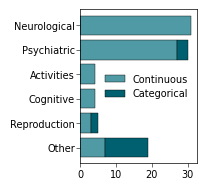

In [292]:
ukb_info_out = ukb_info_out[ukb_info_out.ga_idx.isin(final_matches.ga_idx.values)]
domains = ukb_info_out[ukb_info_out.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains['count']>=2]
other=domains[~domains.Domain.isin(domains_plot.Domain.values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = ukb_info_out[ukb_info_out.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domains_plot.Domain.values)]
other2=domains[~domains.Domain.isin(domains_plot2.Domain.values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(1.5, 2))
pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1].plot(kind='barh', stacked=True, ax=plt.gca(),
                                                                              edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.xticks([0, 10, 20, 30])
#plt.savefig(os.path.join(figdir, 'UKB_input_trait_types.svg'), bbox_inches='tight')

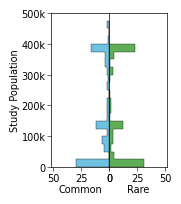

In [293]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2), sharey=True, gridspec_kw={'wspace':0})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= final_matches.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= final_matches.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(52, 0)
ax2.set_xlim(0, 52)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([50, 25, 0])
ax2.set_xticks([0, 25, 50])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)
#plt.savefig(os.path.join(figdir, 'population_size_histograms_ukb.svg'), bbox_inches='tight')

In [295]:
ukb_info_out = ukb_info_out[ukb_info_out.ga_idx.isin(final_matches.ga_idx.values)]

In [303]:
ukb_info_out.merge(final_matches, on=['ga_idx', 'Trait']).loc[:, ('Trait', 'N_C', 'N_R', 'Domain' ,'trait_type')].to_csv(os.path.join(datadir, 'inputs/UKB/input_figure_metadata.tsv'), sep='\t', index=False)